# Annotate TSS of peaks using CellOracle
**Authorship:** Adam Klie (last updated: 08/15/2023)<br>
***
**Description:** This notebook annotates peaks for nearby TSS's and then uses that to find peak to gene links

# Set-up

In [24]:
# Global imports
import os
import sys
import shutil
import importlib
import glob
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

# Celloracle imports
from celloracle import motif_analysis as ma
from pybedtools import BedTool
import celloracle as co

0.14.0


In [ ]:
# Notebook settings
%matplotlib inline

In [ ]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"

# Inputs
cicero_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/cicero/results"
in_date = "10Aug23"
in_dir = os.path.join(cicero_dir, dataset_name, in_date)
print(in_dir)

# Outputs
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results"
analysis = "base_grn_construction"
#out_date = datetime.datetime.now().strftime("%d%b%y").lower()
out_date = "10Aug23"
out_dir = os.path.join(results_dir, dataset_name, out_date, analysis)
make_dirs(out_dir)

In [ ]:
# Make and log a yaml file with the parameters
data_params = {
    "dataset_name": dataset_name,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_date": out_date,
    "out_dir": out_dir,
    "random_state": random_state,
}
version_params = {
    "Python": sys.version[:5],
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "scanpy": sc.__version__,
    "seaborn": sns.__version__,
}
params = {"data": data_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "tss_annotation_params.yaml")):
    with open(os.path.join(out_dir, "tss_annotation_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load and format peaks

In [115]:
# Load scATAC-seq peak list.
peaks = pd.read_csv(os.path.join(in_dir, "all_peaks.csv"), header=None, skiprows=1)[0].values
peaks = [peak.replace("-", "_") for peak in peaks]
len(peaks), peaks[:5]

(262611,
 ['chr1_9720_10674',
  'chr1_28830_29744',
  'chr1_180609_181647',
  'chr1_183869_184817',
  'chr1_186252_187321'])

In [116]:
# Create bedtool object
peaks_df = ma.process_bed_file.list_peakstr_to_df(peaks)
peaks_bed = BedTool.from_dataframe(peaks_df)
peaks_df.head()

,chr,start,end
0,chr1,9720,10674
1,chr1,28830,29744
2,chr1,180609,181647
3,chr1,183869,184817
4,chr1,186252,187321


# Load co-accessibility results

In [117]:
# Load the connections
cicero_connections = pd.read_csv(os.path.join(cicero_dir, dataset_name, now, "all_cicero_connections.csv"), index_col=0)
print(cicero_connections.shape)
cicero_connections.head()

(42336346, 3)


,Peak1,Peak2,coaccess
1,chr10_100001507_100002234,chr10_99519917_99520833,-0.000136
2,chr10_100001507_100002234,chr10_99521238_99521908,0.000036
3,chr10_100001507_100002234,chr10_99522692_99523572,0.000056
4,chr10_100001507_100002234,chr10_99527111_99528124,-0.000020
5,chr10_100001507_100002234,chr10_99529711_99531673,0.000005


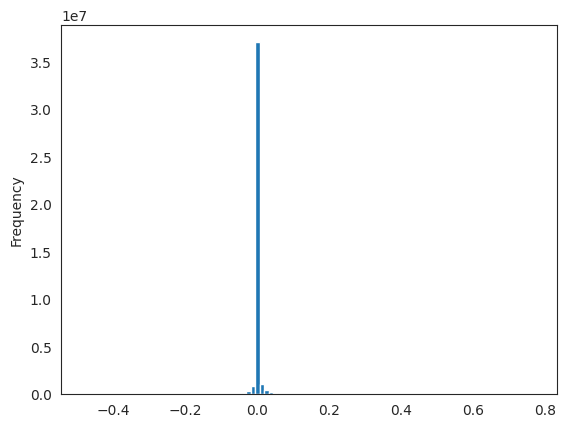

In [118]:
# Plot the score distributions
cicero_connections.coaccess.plot.hist(bins=100)
plt.show()

In [123]:
cicero_play = cicero_connections.copy()

In [124]:
cicero_play = cicero_play[cicero_play["coaccess"] > 0]

In [152]:
# Create a temporary column with sorted combinations
cicero_play['temp'] = cicero_play.apply(lambda row: tuple(sorted([row['Peak1'], row['Peak2']])), axis=1)

# Drop duplicates based on the temporary column
cicero_play = cicero_play.drop_duplicates(subset='temp').drop(columns='temp')

In [172]:
cicero_play["Peak1_class"] = cicero_play["Peak1"].isin(tss["peak_id"]).replace({True: "P", False: "C"})
cicero_play["Peak2_class"] = cicero_play["Peak2"].isin(tss["peak_id"]).replace({True: "P", False: "C"})
cicero_play.head()

,Peak1,Peak2,coaccess,help,Peak1_class,Peak2_class,link_class
2,chr10_100001507_100002234,chr10_99521238_99521908,3.621887e-05,True,C,C,CC
3,chr10_100001507_100002234,chr10_99522692_99523572,5.562750e-05,True,C,C,CC
5,chr10_100001507_100002234,chr10_99529711_99531673,5.094770e-06,True,C,P,CC
7,chr10_100001507_100002234,chr10_99534959_99535936,1.804878e-07,True,C,C,CC
8,chr10_100001507_100002234,chr10_99536633_99537500,8.838744e-05,True,C,C,CC


In [173]:
cicero_play["link_class"] = cicero_play["Peak1_class"] + cicero_play["Peak2_class"]

In [184]:
cicero_play["link_class"].replace({"PP": "promoter-promoter", "PC": "cRE-promoter", "CP": "cRE-promoter", "CC": "cRE-cRE"}, inplace=True)

In [196]:
result_df = pd.DataFrame(cicero_play["link_class"].value_counts())
result_df.columns = [0]
for coaccess_thresh in np.arange(0.05, 1, 0.05):
    cicero_play_tmp = cicero_play[cicero_play["coaccess"] > coaccess_thresh]
    curr_df = pd.DataFrame(cicero_play_tmp["link_class"].value_counts())
    curr_df.columns = [coaccess_thresh]
    result_df = pd.concat([result_df, curr_df], axis=1)
result_df.fillna(0, inplace=True)

In [197]:
result_df

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
cRE-cRE,7217606,57899,17299,7441,2987,939,343,158,79,59,30,20.0,13.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0
cRE-promoter,1310829,23314,3790,1247,443,153,81,39,26,16,11,6.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
promoter-promoter,127101,15667,2227,569,170,50,21,8,3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
cicero_play_tmp 

,Peak1,Peak2,coaccess,help,Peak1_class,Peak2_class,link_class
440,chr10_100009436_100010350,chr10_99536633_99537500,0.097237,True,P,C,PC
448,chr10_100009436_100010350,chr10_99620334_99621209,0.066246,True,P,P,PP
460,chr10_100009436_100010350,chr10_99731798_99732669,0.075891,True,P,P,PP
554,chr10_100009436_100010350,chr10_100535422_100536351,0.082562,True,P,P,PP
587,chr10_100009436_100010350,chr10_100728972_100729918,0.061627,True,P,C,PC
...,...,...,...,...,...,...,...
42587824,chrY_4999812_5000682,chrY_5000697_5001440,0.154390,True,P,C,PC
42588071,chrY_6748124_6748706,chrY_6748814_6749673,0.240512,True,C,C,CC
42588299,chrY_6908811_6909632,chrY_6910276_6911213,0.056348,True,C,P,CP
42588724,chrY_7084364_7085092,chrY_7085356_7086281,0.071537,True,C,C,CC


# Load TSS info

In [156]:
# UCSC TSS annotation for hg38 (must just be a downloadable file)
ref_bed = ma.tss_annotation._load_tss_ref_data("hg38")
ref_df = ref_bed.to_dataframe().head()
ref_df.head()

,chrom,start,end,name,score,strand
0,chr7,130668658,130669758,COPG2,-450,-
1,chr3,12795672,12796772,CAND2,-458,+
2,chr1,207053376,207053980,PFKFB2,403,-
3,chr17,4582981,4583538,SMTNL2,-747,+
4,chr22,15820784,15821884,BMS1P22,-450,-


In [157]:
# Or let CellOracle do it for you
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="hg38")
tss_annotated.tail()

que bed peaks: 262611
tss peaks in que: 25535


,chr,start,end,gene_short_name,strand
25530,chr1,10430128,10431097,CENPS-CORT,+
25531,chr11,126655105,126656263,LOC101929427,+
25532,chr5,149551086,149552027,CSNK1A1,-
25533,chr20,10673764,10674635,JAG1,-
25534,chr9,122228199,122229187,LHX6,-


# Intersect TSS with peaks

In [158]:
# Do the intersection
intersected_bed = ref_bed.intersect(peaks_bed, wb=True)
intersected_df = intersected_bed.to_dataframe()

# Clean up the df
intersected_df = intersected_df.rename(columns={"start": "start_intersected_df", "end": "end_intersected_df", "name": "gene_short_name"})
intersected_df["intersection_length"] = intersected_df["end_intersected_df"] - intersected_df["start_intersected_df"]
intersected_df = intersected_df.rename(columns={"thickStart": "chr", "thickEnd": "start", "itemRgb": "end"})
intersected_df = intersected_df[["chr", "start", "end", "gene_short_name", "strand", "intersection_length"]]
intersected_df.head()

,chr,start,end,gene_short_name,strand,intersection_length
0,chr7,130668130,130669087,COPG2,-,429
1,chr3,12796317,12797202,CAND2,+,455
2,chr1,207052690,207053632,PFKFB2,-,256
3,chr10,96043099,96043983,CCNJ,+,403
4,chr1,161225478,161226409,MIR5187,+,223


# Intersect this with Cicero links

In [159]:
tss = pd.DataFrame({"peak_id": ma.process_bed_file.df_to_list_peakstr(tss_annotated), "gene_short_name": tss_annotated.gene_short_name.values})
tss.head()

,peak_id,gene_short_name
0,chr7_130668130_130669087,COPG2
1,chr3_12796317_12797202,CAND2
2,chr1_207052690_207053632,PFKFB2
3,chr10_96043099_96043983,CCNJ
4,chr1_161225478_161226409,MIR5187


In [134]:
tss = pd.DataFrame({"peak_id": ma.process_bed_file.df_to_list_peakstr(intersected_df), "gene_short_name": intersected_df.gene_short_name.values})
tss.head()

,peak_id,gene_short_name
0,chr7_130668130_130669087,COPG2
1,chr3_12796317_12797202,CAND2
2,chr1_207052690_207053632,PFKFB2
3,chr10_96043099_96043983,CCNJ
4,chr1_161225478_161226409,MIR5187


In [135]:
len(tss)

25535

In [136]:
# Each cicero link is purposely duplicated to make it easier to do stuff like this! :) If you switch to Peak2 you get the same thing.
cicero_tss = pd.merge(cicero_connections, tss.rename(columns={"peak_id": "Peak1"}), on="Peak1", how="inner")
cicero_tss

,Peak1,Peak2,coaccess,gene_short_name
0,chr10_100009436_100010350,chr10_99519917_99520833,0.041711,DNMBP
1,chr10_100009436_100010350,chr10_99521238_99521908,0.000818,DNMBP
2,chr10_100009436_100010350,chr10_99522692_99523572,0.004438,DNMBP
3,chr10_100009436_100010350,chr10_99527111_99528124,0.006661,DNMBP
4,chr10_100009436_100010350,chr10_99529711_99531673,0.011738,DNMBP
...,...,...,...,...
4359420,chrY_7273541_7274654,chrY_7835286_7836156,0.000000,PRKY
4359421,chrY_7273541_7274654,chrY_7836708_7837754,0.000000,PRKY
4359422,chrY_7273541_7274654,chrY_7860615_7861546,0.000000,PRKY
4359423,chrY_7273541_7274654,chrY_7866732_7867690,0.000000,PRKY


In [137]:
cicero_tss = cicero_tss.rename(columns={"Peak2": "peak_id"})[["peak_id", "gene_short_name", "coaccess"]]

In [138]:
cicero_tss = cicero_tss[cicero_tss.coaccess > 0]
cicero_tss

,peak_id,gene_short_name,coaccess
0,chr10_99519917_99520833,DNMBP,0.041711
1,chr10_99521238_99521908,DNMBP,0.000818
2,chr10_99522692_99523572,DNMBP,0.004438
3,chr10_99527111_99528124,DNMBP,0.006661
4,chr10_99529711_99531673,DNMBP,0.011738
...,...,...,...
4359397,chrY_6964505_6965490,PRKY,0.000103
4359400,chrY_6997195_6998192,PRKY,0.000283
4359414,chrY_7272200_7273051,PRKY,0.050342
4359417,chrY_7560885_7561916,PRKY,0.037414


In [143]:
tss["coaccess"] = 1

In [144]:
cicero_tss

,peak_id,gene_short_name,coaccess
0,chr10_99519917_99520833,DNMBP,0.041711
1,chr10_99521238_99521908,DNMBP,0.000818
2,chr10_99522692_99523572,DNMBP,0.004438
3,chr10_99527111_99528124,DNMBP,0.006661
4,chr10_99529711_99531673,DNMBP,0.011738
...,...,...,...
4359397,chrY_6964505_6965490,PRKY,0.000103
4359400,chrY_6997195_6998192,PRKY,0.000283
4359414,chrY_7272200_7273051,PRKY,0.050342
4359417,chrY_7560885_7561916,PRKY,0.037414


In [145]:
merged = pd.concat([cicero_tss, tss], axis=0)
merged

,peak_id,gene_short_name,coaccess
0,chr10_99519917_99520833,DNMBP,0.041711
1,chr10_99521238_99521908,DNMBP,0.000818
2,chr10_99522692_99523572,DNMBP,0.004438
3,chr10_99527111_99528124,DNMBP,0.006661
4,chr10_99529711_99531673,DNMBP,0.011738
...,...,...,...
25530,chr1_10430128_10431097,CENPS-CORT,1.000000
25531,chr11_126655105_126656263,LOC101929427,1.000000
25532,chr5_149551086_149552027,CSNK1A1,1.000000
25533,chr20_10673764_10674635,JAG1,1.000000


In [150]:
merged[merged[['peak_id', 'gene_short_name']].duplicated()]

,peak_id,gene_short_name,coaccess
1076,chr10_99519917_99520833,BLOC1S2,0.003484
1077,chr10_99519917_99520833,BLOC1S2,0.003484
1082,chr10_99522692_99523572,BLOC1S2,0.006980
1083,chr10_99522692_99523572,BLOC1S2,0.006980
1085,chr10_99527111_99528124,BLOC1S2,0.005662
...,...,...,...
25517,chr9_4984548_4985509,JAK2,1.000000
25529,chr14_71931921_71932853,RGS6,1.000000
25530,chr1_10430128_10431097,CENPS-CORT,1.000000
25532,chr5_149551086_149552027,CSNK1A1,1.000000


In [109]:
merged = merged.groupby(by=["peak_id", "gene_short_name"]).max()
merged

coaccess
peak_id                   gene_short_name              
chr10_100001507_100002234 ABCC2            1.503991e-07
                          BLOC1S2          9.144155e-03
                          COX15            3.115379e-05
                          CUTC             3.115379e-05
                          ERLIN1           6.414962e-04
...                                                 ...
chrY_7272200_7273051      TBL1Y            1.456596e-02
chrY_7273541_7274654      PRKY             1.000000e+00
                          TBL1Y            1.605439e-02
chrY_7560885_7561916      PRKY             3.741382e-02
chrY_7818665_7819725      PRKY             1.252186e-03

[1541352 rows x 1 columns]

In [111]:
merged = merged.reset_index()

In [112]:
merged

,peak_id,gene_short_name,coaccess
0,chr10_100001507_100002234,ABCC2,1.503991e-07
1,chr10_100001507_100002234,BLOC1S2,9.144155e-03
2,chr10_100001507_100002234,COX15,3.115379e-05
3,chr10_100001507_100002234,CUTC,3.115379e-05
4,chr10_100001507_100002234,ERLIN1,6.414962e-04
...,...,...,...
1541347,chrY_7272200_7273051,TBL1Y,1.456596e-02
1541348,chrY_7273541_7274654,PRKY,1.000000e+00
1541349,chrY_7273541_7274654,TBL1Y,1.605439e-02
1541350,chrY_7560885_7561916,PRKY,3.741382e-02


In [8]:
# Integrate the TSS peak with the Cicero connections
integrated = ma.integrate_tss_peak_with_cicero(
    tss_peak=tss_annotated,
    cicero_connections=cicero_connections
)
print(integrated.shape)
integrated.head()

(1541352, 3)


,peak_id,gene_short_name,coaccess
0,chr10_100001507_100002234,ABCC2,1.503991e-07
1,chr10_100001507_100002234,BLOC1S2,9.144155e-03
2,chr10_100001507_100002234,COX15,3.115379e-05
3,chr10_100001507_100002234,CUTC,3.115379e-05
4,chr10_100001507_100002234,ERLIN1,6.414962e-04


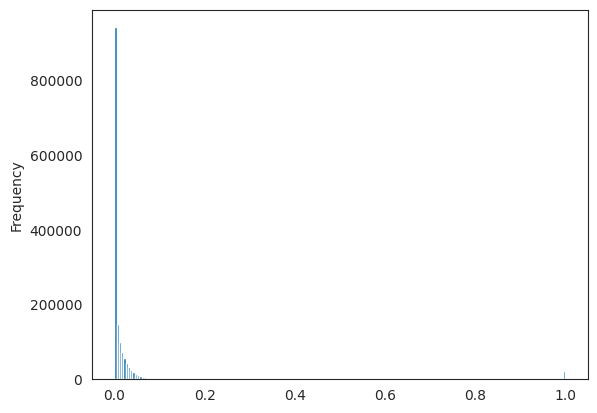

In [19]:
integrated.coaccess.plot.hist(bins=200)
plt.show()

In [25]:
(integrated.coaccess == 1).sum()

23434

# Post-process and save

In [198]:
# Keep only peaks with coaccessibility >= 0.8
peak = integrated[integrated.coaccess >= 0.1]
peak = peak[["peak_id", "gene_short_name"]].reset_index(drop=True)
print(peak.shape)
peak.head()

(31140, 2)


,peak_id,gene_short_name
0,chr10_100009436_100010350,DNMBP
1,chr10_100081010_100082022,CPN1
2,chr10_100185574_100186492,ERLIN1
3,chr10_100229112_100229961,CHUK
4,chr10_100267214_100268148,CWF19L1


In [28]:
tss_annotated["peak_id"] = tss_annotated["chr"] + "_" + tss_annotated["start"].astype(str) + "_" + tss_annotated["end"].astype(str)

In [37]:
peak[~(peak["peak_id"].isin(tss_annotated["peak_id"]))]

,peak_id,gene_short_name
37,chr10_101694021_101694742,FBXW4
40,chr10_101778698_101779523,FGF8
69,chr10_102450147_102451035,RPARP-AS1
71,chr10_102501918_102502468,ACTR1A
72,chr10_102501918_102502468,SUFU
...,...,...
31093,chrX_83508794_83509700,POU3F4
31114,chrY_12662925_12663760,TTTY15
31119,chrY_13751156_13752068,TMSB4Y
31122,chrY_14525330_14525991,NLGN4Y


In [199]:
# Save to the base GRN output dir
peak.to_csv(os.path.join(out_dir, "processed_peak_file.csv"))

# DONE!

---